# EDLIF model

[Jaras I, Harada T, Orchard ME, Maldonado PE, Vergara RC. Extending the integrate-and-fire model to account for metabolic dependencies. Eur J Neurosci. 2021 Aug;54(4):5249-5260. doi: 10.1111/ejn.15326. Epub 2021 Jul 16. PMID: 34109698.](https://onlinelibrary.wiley.com/doi/10.1111/ejn.15326)

[Free full article](https://www.researchgate.net/publication/352298690_Extending_the_integrate-and-fire_model_to_account_for_metabolic_dependencies)

### TODO:
- [] include equations

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest
import numpy as np
import os

from pynestml.frontend.pynestml_frontend import generate_nest_target

NEST_SIMULATOR_INSTALL_LOCATION = nest.ll_api.sli_func("statusdict/prefix ::")


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: master@61f08e0ea
 Built: Jul 14 2022 17:28:07

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
load_module = True
kernel = "exp"

if load_module:
    if kernel == "alpha":
        module_name = "edlif_psc_alpha_0_module"
        neuron_model = ["edlif_psc_alpha_percent0_nestml__with_ed_stdp0_nestml.nestml"]
    elif kernel == "exp":
        module_name = "edlif_psc_exp_1_module"
        neuron_model = ["edlif_psc_exp_percent1_nestml__with_ed_stdp1_nestml.nestml"]
    nest.Install(module_name)
    
    neuron_id = 0
else:
    neuron_model = [
        "edlif_psc_base.nestml", 
        "edlif_psc_nonlineardendrite.nestml",
        "edlif_psc_supply_state.nestml",
        "edlif_psc_supply_inline.nestml",
        "edlif_psc_percent.nestml",
        "../network/models/neurons/edlif_psc_alpha_percent.nestml"
    ]
    neuron_id = 5
    generate_nest_target(input_path=neuron_model[neuron_id],
                         target_path="/tmp/nestml-component",
                         logging_level="INFO",
                         codegen_opts={"nest_path": NEST_SIMULATOR_INSTALL_LOCATION})
    
    nest.Install("nestmlmodule")


Nov 02 10:35:18 Install [Info]: 
    loaded module edlif_psc_exp_1_module


In [3]:
def expected_fr(t_ref, tau_m, v_th, v_res, i_e, c):
    fr = (t_ref - tau_m*np.log(1-((v_th - v_res)/(i_e*(tau_m/c)))))**-1
    return fr*1000

def expected_fr_w_weight(t_ref, tau_m, v_th, v_res, i_e, c, w, fr_pre, tau_s = 1, len_pre_pop = 1):
    fr = (t_ref - tau_m*np.log(1-((v_th - v_res - len_pre_pop*w*fr_pre/1000*tau_s**-1)/(i_e*(tau_m/c)))))**-1
    return fr*1000

Using neuron model: edlif_psc_exp_percent1_nestml__with_ed_stdp1_nestml
 source   target   synapse model   weight   delay 
-------- -------- --------------- -------- -------
      1        2  static_synapse    0.000   1.000
      1       40  static_synapse    0.000   1.000
      1        4  static_synapse    0.000   1.000
      1        5  static_synapse    0.000   1.000
      1        6  static_synapse    0.000   1.000
      1        7  static_synapse    0.000   1.000
      1        8  static_synapse    0.000   1.000
      1        9  static_synapse    0.000   1.000
      1       10  static_synapse    0.000   1.000
      1       11  static_synapse    0.000   1.000
      1       12  static_synapse    0.000   1.000
      1       13  static_synapse    0.000   1.000
      1       14  static_synapse    0.000   1.000
      1        3  static_synapse    0.000   1.000
      1       16  static_synapse    0.000   1.000
     ⋮        ⋮               ⋮        ⋮       ⋮ 
      1       37  static_s

/tmp/ipykernel_12458/2605712962.py:146: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
/tmp/ipykernel_12458/2605712962.py:146: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


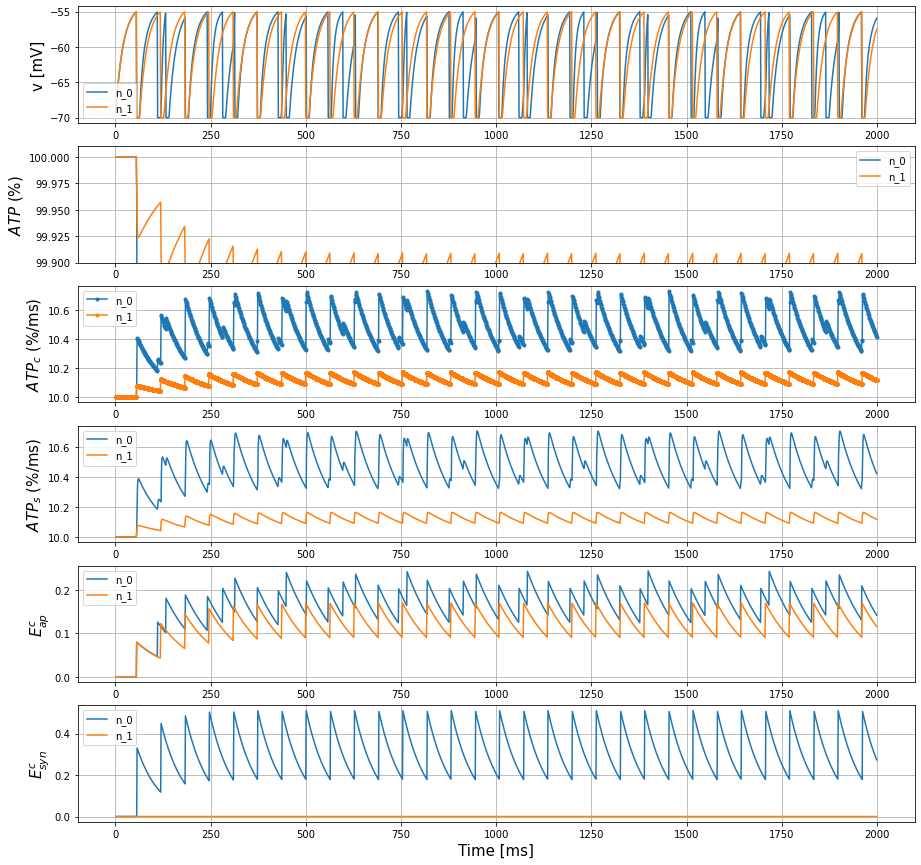

In [4]:
nest.set_verbosity("M_WARNING")
nest.ResetKernel()

neuron_model_name = neuron_model[neuron_id].split(".")[0]
print(f"Using neuron model: {neuron_model_name}")

#param dict
parameter_dict = {"K_ATP": [1, 1], "ATP": [100, 100]}
n = 1
n_pop_2 = 50
# current generator
current_generator = False

# create neurons
pop1 = nest.Create(neuron_model_name, n)#, params=parameter_dict)
pop2 = nest.Create(neuron_model_name, n_pop_2)#, params=parameter_dict)
voltmeter1 = nest.Create("voltmeter")
voltmeter2 = nest.Create("voltmeter")
voltmeter = [voltmeter1, voltmeter2]

for neuron in [pop1, pop2]:
    neuron.tau_m = 20 #20
    neuron.tau_syn_ex = 6
    neuron.tau_syn_in = 6
    neuron.C_m = 250 #250
    neuron.t_ref = 8 #2
    # energy params
    neuron.K_ATP = 1
    neuron.gamma = 178*0
    neuron.tau_ap = 100
    neuron.E_ap = 8
    neuron.E_rp = 5
    neuron.E_hk = 5
    neuron.E_syn_ex = 4
    neuron.E_syn_in = 4
    neuron.tau_syn_atp_ex = 60
    neuron.tau_syn_atp_in = 60
    neuron.w_max = 100
    neuron.w_min = 100
# create connections
#syn_dict = {"synapse_model": synapse_model[0], 
#            "w": -100,
#            #"alpha": 1
#            }
syn_dict = {"synapse_model": 'static_synapse', 
            "weight": 0,
            #"alpha": 1
            }
nest.Connect(pop1, pop2,
             syn_spec=syn_dict)
print(nest.GetConnections())

#syn_dict2 = {"synapse_model": synapse_model[0], 
#            "w": 100,
#            #"alpha": 1
#            }
syn_dict2 = {"synapse_model": 'static_synapse', 
            "weight": 10,
            #"alpha": 1
            }
nest.Connect(pop2, pop1,
             syn_spec=syn_dict2)




voltmeter[0].set({"record_from": ["V_m", "ATP", "ATP_c", "ATP_s", "E_ap_tr", "E_ap_c", "E_syn_c"]}) #, "E_ap_der", "E_ap_tr2"]})
voltmeter[1].set({"record_from": ["V_m", "ATP", "ATP_c", "ATP_s", "E_ap_tr", "E_ap_c", "E_syn_c"]}) #, "E_ap_der", "E_ap_tr2"]})
nest.Connect(voltmeter1, pop1)
nest.Connect(voltmeter2, pop2)

# current generators
if current_generator:
    dcs = nest.Create('dc_generator')
    dcs.set({"amplitude": 200.01})   
    dcs.set({"stop": 1500})
    acs = nest.Create('ac_generator')
    acs.set({"amplitude": 150.2})
    acs.set({"offset": 150.2})
    acs.set({"frequency": 10})
    acs.set({"stop": 1500})
    nest.Connect(dcs, pop1)
    nest.Connect(acs, pop2)
else:
    pop1.I_e = 200
    pop2.I_e = 200



# spike recorder
sr = nest.Create("spike_recorder")
nest.Connect(pop1, sr)
nest.Connect(pop2, sr)

simtime = 1000.*2
nest.Simulate(simtime)

# new arrays for reshaped arrays
ts = []
Vms = []
atp = []
atp_h = []
atp_c = []
atp_s = []
e_ap_c = []
e_syn_c = []
st = []

fontsize = 15
fig, ax = plt.subplots(nrows=6, figsize=(15,15))

for idx in range(2):
    # reshape arrays
    print(f"idx: {idx}")
    ts.append(voltmeter[idx].get("events")["times"])
    Vms.append(voltmeter[idx].get("events")["V_m"])
    atp.append(voltmeter[idx].get("events")["ATP"])
    atp_h.append(pop1.get("ATP_h"))
    atp_c.append(voltmeter[idx].get("events")["ATP_c"])
    atp_s.append(voltmeter[idx].get("events")["ATP_s"])
    e_ap_c.append(voltmeter[idx].get("events")["E_ap_c"])
    e_syn_c.append(voltmeter[idx].get("events")["E_syn_c"])
    
    # plot
    ax[0].plot(ts[idx], Vms[idx], label=f"n_{idx}")
    ax[1].plot(ts[idx], atp[idx], label=f"n_{idx}")
    ax[1].set_ylim(99.9, 100.01)
    #ax[1].axhline(y=atp_h[idx], ls="--")
    ax[2].plot(ts[idx], atp_c[idx], marker ='.', label=f"n_{idx}")
    #ax[2].axhline(y=pop1.get("ATP_basal"), ls="--")
    ax[3].plot(ts[idx], atp_s[idx], label=f"n_{idx}")
    ax[4].plot(ts[idx], e_ap_c[idx], label=f"n_{idx}")
    ax[5].plot(ts[idx], e_syn_c[idx], label=f"n_{idx}")
    for _ax in ax:
        _ax.grid(True)
        _ax.legend()
    ax[0].set_ylabel("v [mV]", fontsize=fontsize)
    ax[1].set_ylabel("$ATP$ (%)", fontsize=fontsize)
    ax[2].set_ylabel("$ATP_c$ (%/ms)", fontsize=fontsize)
    ax[3].set_ylabel("$ATP_s$ (%/ms)", fontsize=fontsize)
    ax[4].set_ylabel("$E_{ap}^{tr}$", fontsize=fontsize)
    ax[4].set_ylabel("$E_{ap}^c$", fontsize=fontsize)
    ax[5].set_ylabel("$E_{syn}^c$", fontsize=fontsize)
    ax[-1].set_xlabel("Time [ms]", fontsize=fontsize)
    
    fig.show()
    

spike_times = len(sr.get("events")["times"])
print(f'spikes times: {spike_times}')
print(f'mean firing rate: {spike_times/(simtime*(len(pop1) + len(pop2))) * 1000}')
e_fr = expected_fr(t_ref=pop2.t_ref[0], 
                   tau_m=pop2.tau_m[0], 
                   v_th=pop2.V_th[0], 
                   v_res=pop2.V_reset[0], 
                   i_e=pop2.I_e[0], 
                   c=pop2.C_m[0])
print(f"expected fr: {e_fr} for pop 2")
print(f"real fr: {(sum(sr.get('events')['senders'] == 2))/simtime*1000} for pop 2")

e_fr_w_w = expected_fr_w_weight(t_ref=pop1.t_ref, 
                               tau_m=pop1.tau_m, 
                               v_th=pop1.V_th, 
                               v_res=pop1.V_reset, 
                               i_e=pop1.I_e, 
                               c=pop1.C_m,
                               w=syn_dict2["weight"],
                               fr_pre=e_fr,
                               len_pre_pop=len(pop2))
e_fr_w_w_w_ts = expected_fr_w_weight(t_ref=pop1.t_ref, 
                               tau_m=pop1.tau_m, 
                               v_th=pop1.V_th, 
                               v_res=pop1.V_reset, 
                               i_e=pop1.I_e, 
                               c=pop1.C_m,
                               w=syn_dict2["weight"],
                               fr_pre=e_fr,
                               tau_s=pop1.tau_syn_ex,
                               len_pre_pop=len(pop2))

print(f"expected fr w weight: {e_fr_w_w} for pop 1")
print(f"expected fr w weight w t_syn: {e_fr_w_w_w_ts} for pop 1")
print(f"real fr: {(sum(sr.get('events')['senders'] == 1))/simtime*1000} for pop 2")

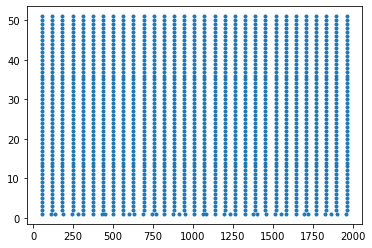

In [5]:
# extracting spikes data
dSD = sr.get("events")
evs = dSD["senders"]
ts = dSD["times"]
plt.plot(ts, evs, ".")

[  55.5   55.5   55.5 ... 1960.5 1960.5 1960.5]
[ 1  2  3 ... 49 50 51]


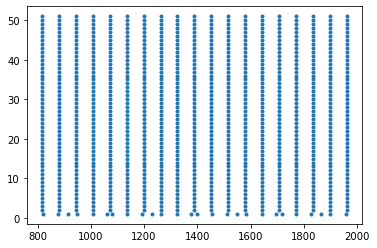

In [6]:
print(ts)
print(evs)
ts_w_min = ts[ts>800]
evs_w_min = evs[ts>800]
ts_w_min_max = ts_w_min[ts_w_min<2000]
evs_w_min_max = evs_w_min[ts_w_min<2000]
plt.plot(ts_w_min_max, evs_w_min_max, ".")

In [7]:
conns = nest.GetConnections(synapse_model="stdp_synapse")

In [8]:
conns.get("weight")

()

In [9]:
conns.get("target")

()

In [10]:
conns.get(["source", "target","weight"])

()